In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_DATA/', one_hot=False)

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [3]:
def weight_tensor(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
def bias_tensor(shape):
    return tf.Variable(tf.zeros(shape)+0.1)

In [4]:
xn = 784 # input dim
hn1 = 400 # hidden dim
hn2 = 400
zn = 2 # latent dim
sn = 10 # sampling number L
bn = 100

## encode

In [5]:
x = tf.placeholder(shape=[None, xn], dtype = tf.float32)

In [6]:
w1 = weight_tensor([xn, hn1])
b1 = bias_tensor([hn1])

h1 = tf.nn.relu(tf.matmul(x, w1) + b1)

In [7]:
w2 = weight_tensor([hn1, hn2])
b2 = bias_tensor([hn2])

h2 = tf.nn.relu(tf.matmul(h1, w2)+b2)

In [8]:
z_mean = tf.matmul(h2, weight_tensor([hn2, zn])) + bias_tensor([zn])
z_log_sig_sq = tf.matmul(h2, weight_tensor([hn2, zn])) + bias_tensor([zn])

In [9]:
## eps를 shape를 sampling number, z dim으로 했는데 수정해야 함(eps가 중복 사용됨)
# eps shape를  batch size * sampling number , z dim 로 수정하기
# eps = tf.random_normal(mean=0, stddev=1, shape=[sn, zn])
# sampled_z_sig = tf.reshape( eps[tf.newaxis,:]* tf.sqrt(tf.exp(z_log_sig_sq))[:,tf.newaxis,:], [-1, zn])
# sampled_z_mean = tf.reshape(tf.ones_like(eps)[tf.newaxis, :]* z_mean[:, tf.newaxis], [-1, zn])

In [10]:
# eps generate
bat_num = tf.shape(x)[0]
eps = tf.random_normal(mean=0, stddev=1, shape=[bat_num*sn, zn])

# duplicate z_sig [bn, zn] --> [bn*sn, zn]
duplicated_z_sig = tf.reshape(tf.ones(shape=[sn,zn])[tf.newaxis,:]*tf.sqrt(tf.exp(z_log_sig_sq))[:,tf.newaxis,:], [-1, zn])

sampled_z_sig = tf.multiply(duplicated_z_sig, eps)
sampled_z_mean = tf.reshape(tf.ones(shape=[sn,zn])[tf.newaxis, :]* z_mean[:, tf.newaxis], [-1, zn])

In [11]:
z = tf.add(sampled_z_mean, sampled_z_sig)

### decode

In [12]:
w3 = weight_tensor([zn, hn2])
b3 = bias_tensor([hn2])

h3 = tf.nn.relu(tf.matmul(z, w3)+ b3)

In [13]:
w4 = weight_tensor([hn2, hn1])
b4 = bias_tensor([hn1])

h4 = tf.nn.relu(tf.matmul(h3, w4)+b4)

In [14]:
xh_mean = tf.sigmoid(tf.matmul(h4, weight_tensor([hn1, xn])) + bias_tensor([xn]))

### loss

In [15]:
# regularization loss
reg_loss = -0.5*tf.reduce_sum(1+ z_log_sig_sq - tf.pow(z_mean,2) - tf.exp(z_log_sig_sq), 1)

In [16]:
duplicated_x = tf.reshape( tf.ones([sn, xn])[tf.newaxis, :] * x[:, tf.newaxis,:], [-1, xn])

In [32]:
# reconstruction loss 
rec_loss = -tf.reduce_sum(duplicated_x * tf.log(1e-10 + xh_mean) + (1-duplicated_x) * tf.log(1e-10 + 1 - xh_mean), 1)
rec_loss = tf.reshape(rec_loss , [-1, sn]) 

# summation sample loss
rec_sum = tf.reduce_sum(rec_loss , 1)
rec_sum = tf.reshape(rec_sum, [-1, 1])

# get importance weight
imp_wet = tf.nn.softmax( rec_loss / rec_sum )

rec_loss = tf.reduce_sum( rec_loss / imp_wet,1)

In [33]:
# calc total loss full batch
total_loss = tf.reduce_mean(reg_loss + rec_loss)

In [34]:
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

In [35]:
epoch = 20000
check_point = 5000

step :  0 time :  0.07648444175720215
total loss :  57370.9
reg loss :  0.0127116
rec loss :  57370.9
latent variable :  [ 0.05232172  0.46708763]


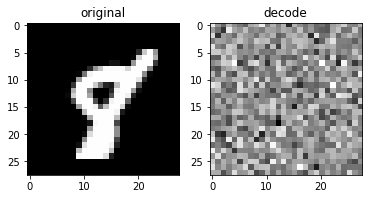

step :  5000 time :  83.18702149391174
total loss :  14020.4
reg loss :  39.063
rec loss :  13981.3
latent variable :  [ 4.07659626  7.59877682]


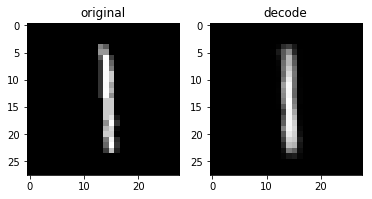

step :  10000 time :  83.77465629577637
total loss :  13382.8
reg loss :  25.347
rec loss :  13357.5
latent variable :  [ 1.13974667 -0.63259113]


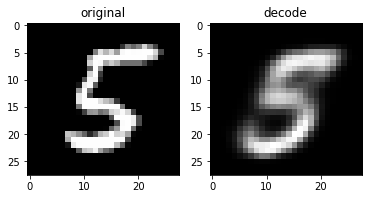

step :  15000 time :  99.17419958114624
total loss :  13383.7
reg loss :  20.5857
rec loss :  13363.1
latent variable :  [ 0.8032614  -3.00727749]


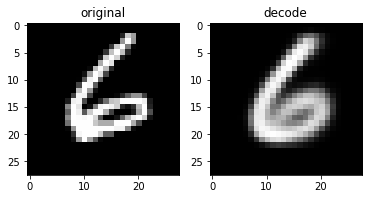

step :  20000 time :  78.41060447692871
total loss :  13091.0
reg loss :  26.0654
rec loss :  13065.0
latent variable :  [-1.58727777 -7.03366184]


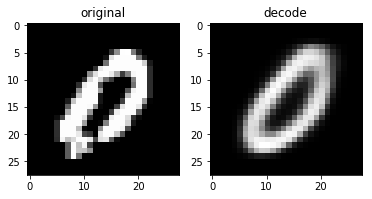

In [36]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
import time
t1 = time.time()
for i in range(epoch+1):
    batch_x,_ = mnist.train.next_batch(bn)
    _, temp_x, temp_z, tloss,rgloss,rcloss = sess.run([train_step,xh_mean, z, total_loss,reg_loss,rec_loss], feed_dict={x:batch_x})
    
    # show results
    if i %check_point==0:
        t2 = time.time()
        print('step : ',i, 'time : ', t2-t1)
        t1 = t2
        
        print('total loss : ', tloss)
        print('reg loss : ', np.mean(rgloss))
        print('rec loss : ', np.mean(rcloss))
        print('latent variable : ', temp_z[0])    
        plt.subplot(1,2,1)
        plt.title('original')
        plt.imshow(batch_x[0].reshape(28,28), cmap='gray')
        plt.subplot(1,2,2)
        plt.title('decode')
        plt.imshow(temp_x[0].reshape(28,28), cmap='gray')
        plt.show()

In [37]:
# latent space walking

z1 = np.linspace(-1,1,10)
z2 = np.linspace(-1,1,10)
test_z = np.zeros([100,2])
test_z = np.array(list(itertools.product(z1,z1)))
ind = 0
for i in z1:
    for j in z2:
        test_z[ind,:] = [i,j]
        ind += 1
        
temp = sess.run(xh_mean, feed_dict={z: test_z })

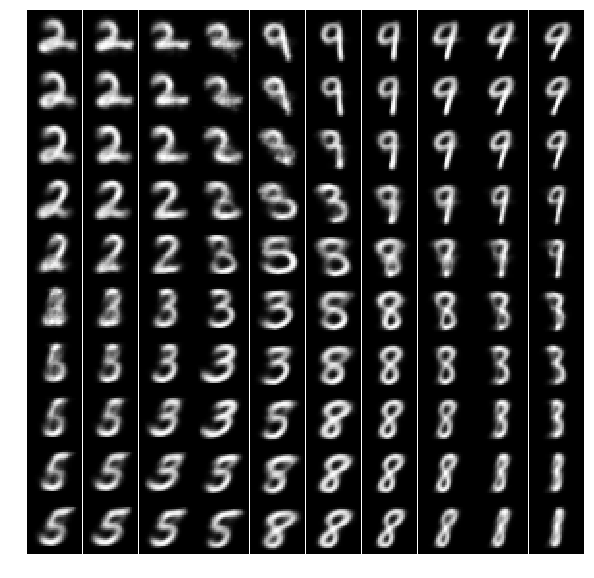

In [38]:
ind = 1
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,ind)
    plt.axis('off')
    plt.imshow(temp[i,:].reshape(28,28), cmap='gray')
    ind += 1
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
